In [ ]:
%matplotlib inline

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


# Eigenfaces: Survey and Implementation from Scratch


### Abstract
The Eigenfaces method is used for face recognition, but the images have high dimensionality. Not all dimensions are equally useful. We need components with the most information, identified through Principal Component Analysis (PCA). PCA reduces correlated variables to a few uncorrelated ones, capturing the most variance. In face recognition, an eigenface is created for each image. By calculating Euclidean distances between this eigenface and stored ones, we identify the closest match, determining who the person resembles most.

## Eigenfaces

**Eigenfaces** are a set of **eigenvectors** used in face recognition. Developed by Sirovich and Kirby (1987) and used by Turk and Pentland, eigenfaces come from the covariance matrix of face images. They reduce dimensions by representing images with fewer basis images. Classification compares faces by this basis set.

Eigenfaces capture variations in face images and encode them holistically. They are the principal components or eigenvectors of the face images' covariance matrix. Developed by Sirovich and Kirby and used by Turk and Pentland, this approach is the first working facial recognition technology and a baseline for modern systems.

**Motivation:**
* Extract facial information, capturing statistical variation.
* Efficiently represent face images, reducing computation and storage.

Eigenfaces are generated by principal component analysis (PCA) on many face images. They act as "standardized face ingredients." Any face can be a combination of these eigenfaces.

### Eigenvalues and Eigenvectors

In linear algebra, an eigenvector of a transformation changes only by a scalar factor. Formally, for a linear transformation $T$ and vector $v$:

$$ T(v) = \lambda v $$

where $ \lambda $ is the eigenvalue.

If $V$ is finite-dimensional, $T$ is a square matrix $A$:

$$ Av = \lambda v $$

Key concepts:
* **Eigensystem:** All eigenvectors with their eigenvalues.
* **Eigenspace:** Eigenvectors with the same eigenvalue plus the zero vector.
* **Eigenbasis:** Eigenvectors forming a basis of T's domain.

### PCA

Principal component analysis (PCA) was invented by Karl Pearson in 1901. It converts correlated variables into uncorrelated principal components. The **first principal component** has the largest variance. PCA is used in data analysis and predictive modeling, visualizing genetic distances, and more. PCA reduces dimensionality by using the first few principal components, explaining the most variance.

### Calculate EigenFaces

Training images should be taken under the same lighting conditions, normalized with aligned eyes and mouths, and resampled to a common resolution (250x250).

#### 1. Read Images
Obtain face images ${\displaystyle I_{1}, I_{2}, ..., I_{n}}$ (training faces). Use **read_images** to read all images from the specified directory. Images are categorized by the person's name, which is stored in a separate array for reference.

In [ ]:
import os
import numpy as np
from PIL import Image
from PIL.Image import Resampling

IMAGE_DIR = 'faces/faces/images'
DEFAULT_SIZE = (100, 100)

def read_images(image_path=IMAGE_DIR, default_size=DEFAULT_SIZE):
    images = []
    image_names = []

    for image_name in os.listdir(image_path):
        if image_name.startswith('.'):
            continue

        image_path_full = os.path.join(image_path, image_name)

        if not os.path.isfile(image_path_full):
            continue

        image = Image.open(image_path_full).convert("L")

        if default_size is not None:
            image = image.resize(default_size, Resampling.LANCZOS)

        images.append(np.asarray(image, dtype=np.uint8))
        image_names.append(image_name)

    return images, image_names



#### 2. Assemble Data Matrix
Represent each image ${I_{i}}$ as a vector $G$, where $G$ is a $1 \times (rc)$ vector, corresponding to an **r × c** face image ${I_{i}}$.

<img src="https://github.com/Ali-Noghabi/eigenfaces/blob/main/image_vector.png?raw=1" />
See [8]

Use the function **as_row_matrix** to assemble the images into a data matrix. **Each row** of the data matrix represents **one image**.

In [ ]:
def as_row_matrix (X):
    if len (X) == 0:
        return np. array ([])
    mat = np. empty ((0 , X [0].size ), dtype =X [0]. dtype )
    for row in X:
        mat = np.vstack(( mat , np.asarray( row ).reshape(1 , -1))) # 1 x r*c
    return mat

#### 3. Compute the Mean Face $\mu$

The mean vector consists of the means of each variable. The variance-covariance matrix has the variances on the main diagonal and the covariances between variable pairs elsewhere .

Calculate the average of the image set as:

$$\mu = \frac{1}{n} \sum_{i=1}^n x_i$$

See [7]

(-0.5, 99.5, 99.5, -0.5)

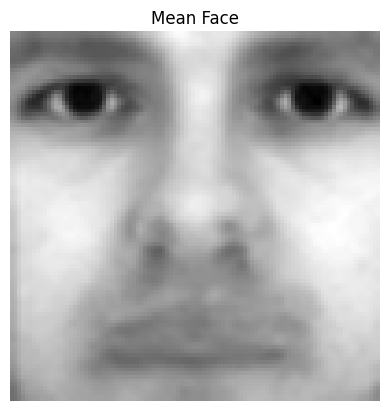

In [ ]:
[X, y] = read_images()
x_temp = as_row_matrix(X)
plt.imshow(np.mean(x_temp,axis=0).reshape(100,100), cmap='gray')
plt.title("Mean Face")
plt.axis('off')

#### 4. Calculate PCA
We define the function **pca** to calculate PCA in these steps:

##### Step 1. Subtract the Mean
Subtract the average image $\mu$ from each original image in $X$.

##### Step 2. Calculate Eigenvectors and Eigenvalues of the Covariance Matrix $S$
A covariance matrix contains variances on the diagonal and covariances between elements elsewhere. Compute the covariance matrix $S$:

$$S = \frac{1}{n} \sum_{i=1}^n (x_i - \mu)(x_i - \mu)^T$$


See [7]

Compute the eigenvalues $\lambda_{i}$ and eigenvectors $v_{i}$ of $S$:

$$Sv_i = \lambda_i v_i, \quad i = 1, 2, \ldots, n$$


See [7]

Eigenvectors have the same dimensionality as the original images and can be seen as images (eigenfaces). They represent the directions in which images differ from the mean image. This step is computationally expensive, but eigenfaces can be computed efficiently without directly computing $S$.

##### Step 3. Choose Principal Components
Sort the eigenvalues in descending order using `np.argsort` and arrange the eigenvectors accordingly. Determine the number of principal components $k$ by setting a threshold $\epsilon$ on the total variance. Total variance ${\displaystyle v=n\cdot (\lambda _{1}+\lambda _{2}+...+\lambda _{n})}$, where $n$ is the number of data images.

Choose $k$ such that:

${\displaystyle {\frac {n(\lambda _{1}+\lambda _{2}+...+\lambda _{k})}{v}}>\epsilon }$

Calculate this using **get_number_of_components_to_preserve_variance** with variance = 0.95.

<img src="https://github.com/Ali-Noghabi/eigenfaces/blob/main/select_eigenfaces.png?raw=1" />

See [6]

The $k$ principal components of the observed vector $x$ are given by:

$$y = W^{T} (x - \mu)$$

where $W = (v_{1}, v_{2}, \ldots, v_{k})$.

See [7]

In [ ]:
from numpy import linalg as LA

def pca (X, y, num_components =0):
    mu = np.mean(X,axis=0)
    X_temp = X - mu.reshape(1,-1)
    Cov = X_temp.T@X_temp

    eigenvalues,eigenvectors = LA.eig(Cov)
    return [ eigenvalues , eigenvectors , mu]

[eigenvalues, eigenvectors, mean] = pca (as_row_matrix(X), y)

In [ ]:
eigenvalues = eigenvalues.real
eigenvectors = eigenvectors.real

idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

Eigenfaces with the highest eigenvalues are called ghost faces. They are shown in the figure below. In some databases, ghost faces are sharp, while in others, they are blurred. The sharpness depends on the backgrounds and details of the images. In this case, the images are very detailed with varying backgrounds, facial expressions, and lighting conditions, resulting in blurred ghost faces. [10]

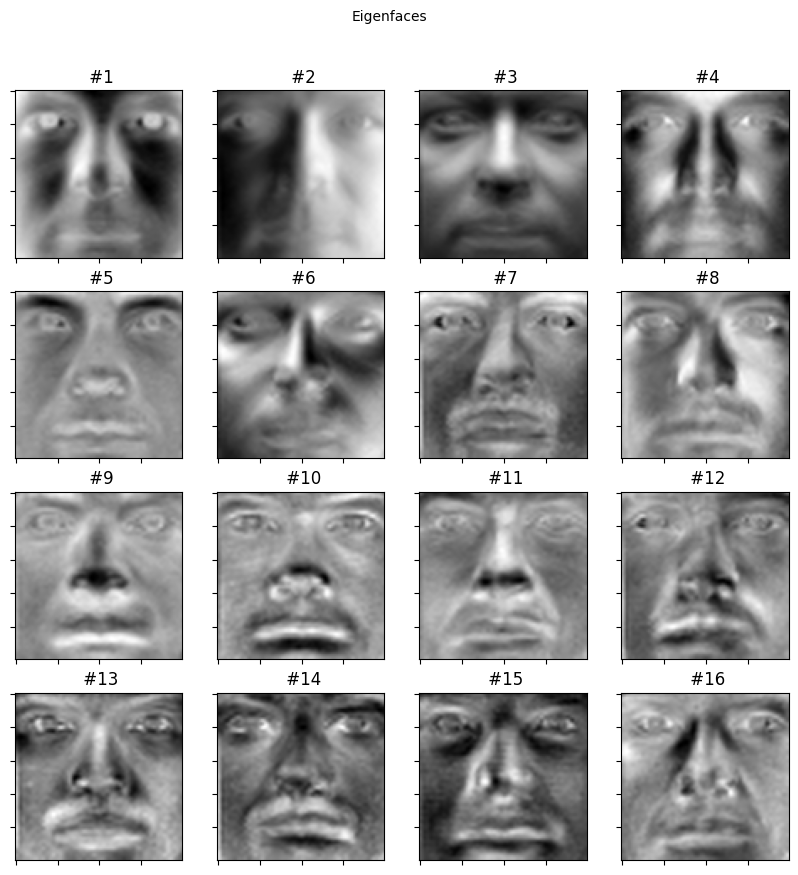

In [ ]:
def subplot ( title , images , rows , cols , sptitle ="", sptitles =[] , colormap = plt.cm.gray, filename = None, figsize = (10, 10) ):
    fig = plt.figure(figsize = figsize)
    # main title
    fig.text (.5 , .95 , title , horizontalalignment ="center")
    for i in range ( len ( images )):
        ax0 = fig.add_subplot( rows , cols ,( i +1))
        plt.setp ( ax0.get_xticklabels() , visible = False )
        plt.setp ( ax0.get_yticklabels() , visible = False )
        if len ( sptitles ) == len ( images ):
            plt.title("%s #%s" % ( sptitle , str ( sptitles [i ]) )  )
        else:
            plt.title("%s #%d" % ( sptitle , (i +1) )  )
        plt.imshow(np.asarray(images[i]) , cmap = colormap )
    if filename is None :
        plt.show()
    else:
        fig.savefig( filename )


E = []
number = eigenvectors.shape[1]
for i in range (min(number, 16)):
    e = eigenvectors[:,i].reshape(X[0].shape )
    E.append(np.asarray(e))
# plot them and store the plot to " python_eigenfaces .pdf"
subplot ( title ="Eigenfaces", images=E, rows =4, cols =4, colormap =plt.cm.gray , filename ="python_pca_eigenfaces.png")

Cumulative sum of first highest eigenvalues

Text(0.5, 1.0, 'Cumulative sim of the first 44 eigenvalues')

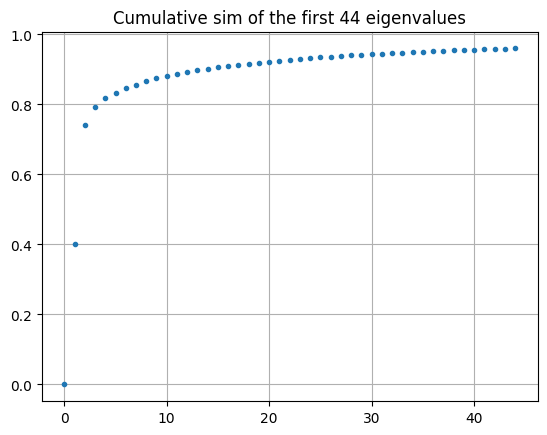

In [ ]:
variance_ratio = eigenvalues / np.sum(eigenvalues)

ls = [0]
sum = 0

for i in range(44):
    sum+=variance_ratio[i]
    ls.append(sum)

plt.plot(ls,'.')
plt.grid(True)
plt.title("Cumulative sim of the first 44 eigenvalues")

##### Representing Faces onto This Basis

Each face can be represented as a linear combination of the eigenfaces. **Each face can also be estimated using the "best" eigenfaces, which have the largest eigenvalues and represent the largest variations in the face image database.** [10]

The reconstruction from the PCA basis is given by:

$$x = W y + \mu$$

where $W = (v_{1}, v_{2}, \ldots, v_{k})$.

See [7]

Each face (minus the mean) ${I_{i}}$ in the training set can be represented as a linear combination of the best $K$ eigenvectors:

<img src="https://github.com/Ali-Noghabi/eigenfaces/blob/main/representation.png?raw=1" />
See [8]

Now we **reconstruct** the first image from the smaller training set:

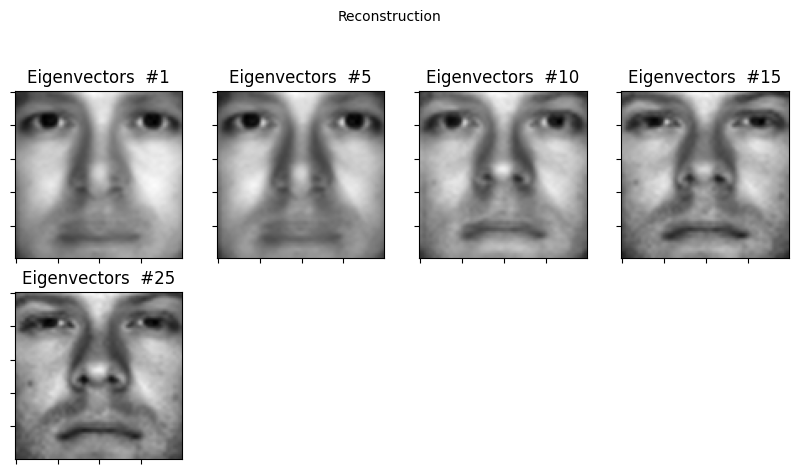

In [ ]:
def project (W , X , mu):
    return np.dot (X - mu , W)
def reconstruct (W , Y , mu) :
    return np.dot (Y , W.T) + mu


[X_small, y_small] = read_images(image_path='faces/faces/images')
[eigenvalues_small, eigenvectors_small, mean_small] = pca (as_row_matrix(X_small), y_small)

steps =[1,5,10,15,25]
E = []

eigenvalues_small = eigenvalues_small.real
eigenvectors_small = eigenvectors_small.real

idx = np.argsort(eigenvalues_small)[::-1]
eigenvalues_small = eigenvalues_small[idx]
eigenvectors_small = eigenvectors_small[:, idx]


for i in range (len(steps)):
    numEvs = steps[i]
    P = project(eigenvectors_small[: ,0: numEvs ], X_small[0].reshape (1 , -1) , mean_small)
    R = reconstruct(eigenvectors_small[: ,0: numEvs ], P, mean_small)
    # reshape and append to plots
    R = R.reshape(X_small[0].shape )
    E.append(np.asarray(R))
subplot ( title ="Reconstruction", images =E, rows =4, cols =4,
         sptitle ="Eigenvectors ", sptitles =steps , colormap =plt.cm.gray , filename ="python_pca_reconstruction.png")

### Conclusion

The Eigenfaces method was applied on small training set of images. The most significant eigenfaces, which have the largest eigenvalues and represent the largest variations in the face image database, were found and shown. Reconstruction of an image was done by representing it as a linear combination of the eigenfaces.



### References

[1] [http://www.scholarpedia.org/article/Eigenfaces]

[2] [https://en.wikipedia.org/wiki/Eigenface]

[3] [https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors]

[4] [https://en.wikipedia.org/wiki/Principal_component_analysis]

[5] [https://github.com/bugra/EigenFace]

[6] [https://www.youtube.com/watch?v=n3sDhHH5tFg]

[7] [https://docs.opencv.org/2.4/modules/contrib/doc/facerec/facerec_tutorial.html]

[8] [http://www.vision.jhu.edu/teaching/vision08/Handouts/case_study_pca1.pdf]

[9] [https://www.itl.nist.gov/div898/handbook/pmc/section5/pmc541.htm]

[10] [https://ac.els-cdn.com/S2212017312000242/1-s2.0-S2212017312000242-main.pdf]

[11] [https://en.wikipedia.org/wiki/Euclidean_distance]